## EDA

In [274]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
# some_file.py
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [275]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

In [276]:
cursor = connection.cursor()
comments_query = "SELECT * FROM Comments"

In [277]:
comments_df = pd.read_sql(comments_query, connection)
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [278]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151515 entries, 0 to 151514
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id_num         151515 non-null  int64 
 1   body           151515 non-null  object
 2   comment_id     151515 non-null  object
 3   parent_id      151515 non-null  object
 4   post_id        151515 non-null  object
 5   author         151515 non-null  object
 6   score          151515 non-null  int64 
 7   comment_class  151515 non-null  object
dtypes: int64(2), object(6)
memory usage: 9.2+ MB


As expected, no missing values

In [279]:
comments_df.duplicated().sum() # Check for dupes, shouldn't have any based on SQL setup

0

### Inspect the score

In [280]:
comments_df.score.describe()

count    151515.000000
mean         27.723678
std         244.380589
min        -148.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       16226.000000
Name: score, dtype: float64

In these political subreddits, if a score is less than zero, we can assume the opinion of the author differs from the general trend of the subreddit. Meaning, if we are on conservative and a comment gets -50, we can infer that the comment was made by someone with an opposing opinion. We don't want these included in our model, since things pulls from r/conservative are meant to be a representation of solely right-leaning thinkers.

We'll use a cut off of 10 for the score to 1) reduce the size of our set and 2) ensure we get comments indicative of the subreddit we are in.

In [281]:
comments_df = comments_df[comments_df.score > 10]

### Inspect the comment length

In [282]:
comments_df.body.apply(len).describe()

count    32889.000000
mean       202.583265
std        345.266462
min          1.000000
25%         61.000000
50%        117.000000
75%        223.000000
max       7708.000000
Name: body, dtype: float64

In [283]:
comments_df = comments_df[comments_df.body.apply(len) >= 100]

We want to reduce the size of our dataframe based on comment body length for two reasons.

1) We need the comment to be long enough such that the way in which a user uses the english language can be accurately measured. It would be hard to judge someone based off a small comment blurb.
2) Since the time we have available for this project is limited, we need to keep our dataframe small enough such that we can run it multiple times. If we include all 150,000 comments, it takes multiple hours to run a single model, and we need to run many, many models. If we had more computing power or more time we would approach this differently.

### Inspect class imbalance after these changes

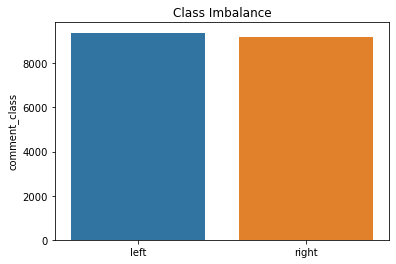

In [284]:
classes = comments_df.comment_class.value_counts()
index = classes.index
sns.barplot(index, classes)
plt.title("Class Imbalance")
plt.savefig("../pics/Class_Imbalance.png")

This class imbalance basically non-existent. In our modeling code, we included a snippet to address class imbalance, so we will probably still use that (upsampling), even if it only adds a very small amount of samples. But, based on the above, we definitely are not obligated to handle any imbalances.

### Investigate sarcasm

In [285]:
def sarcasm(sen):
    return " /s" in sen

In [286]:
comments_df['sarcastic'] = comments_df.body.apply(sarcasm)

In [287]:
comments_df[comments_df.sarcastic == True].comment_class.value_counts()

right    51
left     26
Name: comment_class, dtype: int64

This could be insightful, but then again, compared to the size of our dataset, there really isn't much data here to go off. Right leaners might be more sarcastic, or maybe it just so happens that this is chance. Hard to make a decision from the amount of sarcasm we detected. Additionally, people might be sarcastic and not know about the "/s" convention in reddit comments. I am sure a lot of sarcasm goes undetected.

### Investigate Profanity

In [292]:
import nltk

In [293]:
def check_profanity(comment):
    profane = pd.read_csv("profane_words.csv", header=None)
    profane = list(profane.loc[:,0])
    count = 0
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(comment)

def check_profanity_count(comment):
    profane = pd.read_csv("profane_words.csv", header=None)
    profane = list(profane.loc[:,0])
    count = 0
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    for word in tokens:
        if word in profane:
            count += 1
    return count

In [294]:
comments_df['profanity_percentage'] = comments_df.body.apply(check_profanity)
comments_df['profanity_count'] = comments_df.body.apply(check_profanity_count)

In [295]:
right = comments_df[comments_df.comment_class == 'right']
left = comments_df[comments_df.comment_class == 'left']

print(f"Right comments with any amount of profanity: {len(right[right.profanity_count > 0])}")
print(f"Left comments with any amount of profanity: {len(left[left.profanity_count > 0])}")
print()

print(f"Right comments with at least 3 profane words: {len(right[right.profanity_count > 2])}")
print(f"Left comments with at least 3 profane words: {len(left[left.profanity_count > 2])}")
print()


print(f"Right comments with at least 5 profane words: {len(right[right.profanity_count > 4])}")
print(f"Left comments with at least 5 profane words: {len(left[left.profanity_count > 4])}")
print()

print(f"Right comments with at least 10 profane words: {len(right[right.profanity_count > 9])}")
print(f"Left comments with at least 10 profane words: {len(left[left.profanity_count > 9])}")
print()

print(f"Right comments with at least 15 profane words: {len(right[right.profanity_count > 14])}")
print(f"Left comments with at least 15 profane words: {len(left[left.profanity_count > 14])}")
print()




Right comments with any amount of profanity: 5593
Left comments with any amount of profanity: 4620

Right comments with at least 3 profane words: 1669
Left comments with at least 3 profane words: 896

Right comments with at least 5 profane words: 549
Left comments with at least 5 profane words: 252

Right comments with at least 10 profane words: 126
Left comments with at least 10 profane words: 49

Right comments with at least 15 profane words: 28
Left comments with at least 15 profane words: 16



In [296]:
right.profanity_percentage.describe()

count    9184.000000
mean        0.005056
std         0.006004
min         0.000000
25%         0.000000
50%         0.003717
75%         0.007937
max         0.040650
Name: profanity_percentage, dtype: float64

In [297]:
left.profanity_percentage.describe()

count    9389.000000
mean        0.003309
std         0.004724
min         0.000000
25%         0.000000
50%         0.000000
75%         0.005587
max         0.046512
Name: profanity_percentage, dtype: float64

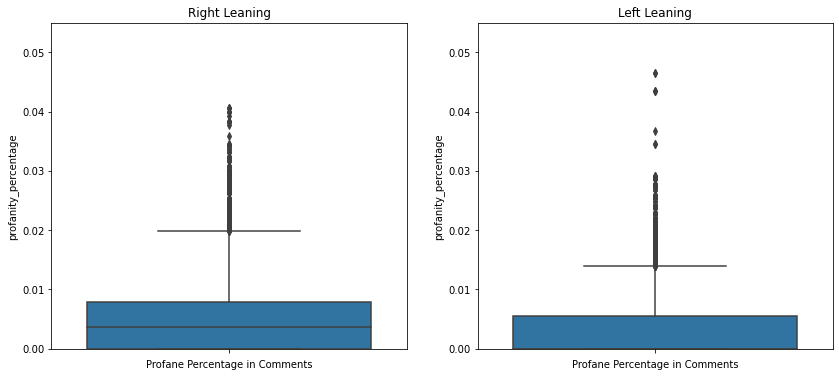

<Figure size 432x288 with 0 Axes>

In [298]:
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot(1, 2, 1)
sns.boxplot(y=right.profanity_percentage, ax=ax1)
plt.xlabel("Profane Percentage in Comments")
plt.ylim(0,.055)
plt.title("Right Leaning")

ax2 = plt.subplot(1, 2, 2)
sns.boxplot(y=left.profanity_percentage, ax=ax2)
plt.xlabel("Profane Percentage in Comments")
plt.ylim(0,.055)
plt.title("Left Leaning")


plt.show()
plt.savefig("../pics/Profanity_Boxplot.png")


In [299]:
right_index = np.arange(0,10)
left_index = np.arange(0,10)

right_values = []
for i in right_index:
    right_values.append(len(right[right.profanity_count >= i]))

left_values = []
for i in right_index:
    left_values.append(len(left[left.profanity_count >= i]))


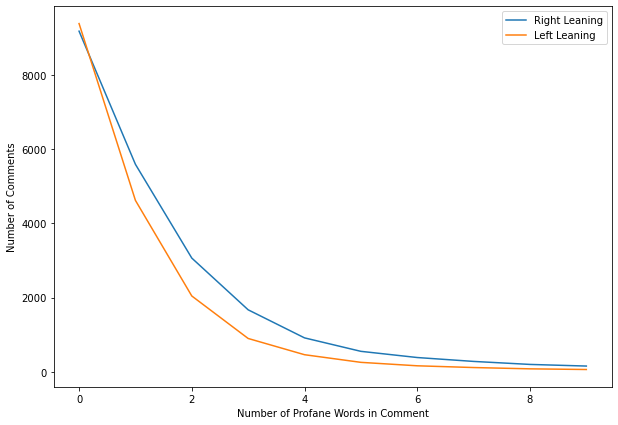

In [300]:
plt.figure(figsize=(10,7))
sns.lineplot(right_index, right_values, label = 'Right Leaning')
sns.lineplot(left_index, left_values, label = 'Left Leaning')
plt.xlabel("Number of Profane Words in Comment")
plt.ylabel("Number of Comments")
plt.legend()
plt.savefig("../pics/Profanity.png")

From the investigation above, we can see that, for whatever reason, the sub-reddits that we deemed to be 'right leaning' tend to use profane words slightly more than the left leaning sub-reddits. This is on average. There are some outliers on the left-leaning side that use a large amount of profanity, but outliers shouldn't be used to make any conclusions in this case, as the count is quite small and likely due to random chance.

Based on the above, we plan to create a feature and include this in our modeling. See modeling notebook for implementation.

#### Verify the Above with a Two Sample t Test!

In [301]:
from scipy.stats import ttest_ind

Ho: Mean use of profanity is equal for right and left leaning subreddits

Ha: Mean use of profanity is NOT equal for right and left leaning subreddits

Using a significance level of .05 and a two sample t test, we will see if we reject or fail to reject the null.

In [302]:
# Variance is not equal, so therefore must use a welch test and set equal_var == False
test_stat, p_value = ttest_ind(right.profanity_percentage, left.profanity_percentage, equal_var=False)
print(f"With a p value of {p_value}, which is far less than our chosen alpha value, we can reject the null")

With a p value of 6.923124610929898e-106, which is far less than our chosen alpha value, we can reject the null


The results from the stats test above further indicate that we should include a feature in our modeling to indicate the use of profanity

### Investigate Use of Words in All Caps

In [303]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [304]:
comments_df['capital_percentage'] = comments_df.body.apply(capital_percentage)

In [305]:
comments_w_most_caps = comments_df.sort_values(by='capital_percentage', 
                                      ascending=False).iloc[0:].comment_class.value_counts()

In [306]:
right = comments_df[comments_df.comment_class == 'right']
left = comments_df[comments_df.comment_class == 'left']

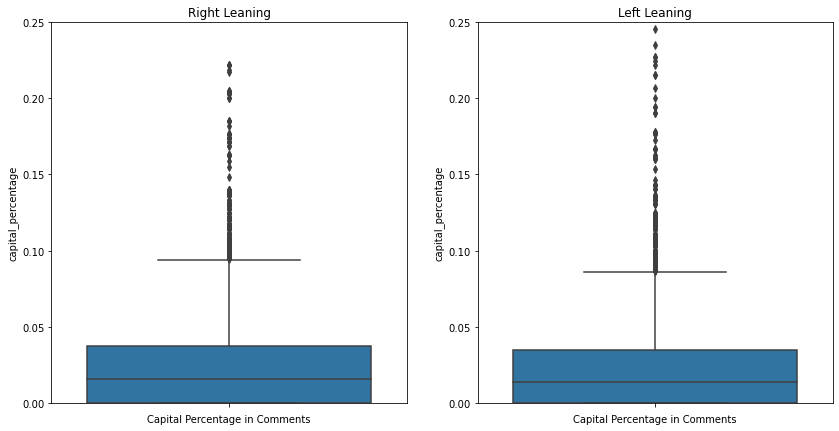

<Figure size 432x288 with 0 Axes>

In [307]:
fig = plt.figure(figsize=(14,7))

ax1 = plt.subplot(1, 2, 1)
sns.boxplot(y=right.capital_percentage, ax=ax1)
plt.xlabel("Capital Percentage in Comments")
plt.ylim(0,.25)
plt.title("Right Leaning")

ax2 = plt.subplot(1, 2, 2)
sns.boxplot(y=left.capital_percentage, ax=ax2)
plt.xlabel("Capital Percentage in Comments")
plt.ylim(0,.25)
plt.title("Left Leaning")


plt.show()
plt.savefig("../pics/Capitalization_Boxplot.png")


Honestly, it doesn't look like much can be taken from this. Yes, the right side, from our source of data uses slightly more capitalization of words, but it is so close that we do not believe it will impact our modeling significantly.

### Create a Word Cloud

In [308]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re"]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [309]:
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [310]:
df_freq_right = comments_df[comments_df['comment_class']=='right']
df_freq_left = comments_df[comments_df['comment_class']=='left']

data_right = df_freq_right['body']
data_left = df_freq_left['body']

processed_right = list(map(process_comment, data_right))
processed_left = list(map(process_comment, data_left))

In [311]:
flat_right = [item for sublist in processed_right for item in sublist]
flat_left = [item for sublist in processed_left for item in sublist]
right_freq = FreqDist(flat_right)
left_freq = FreqDist(flat_left)

In [312]:
# create counts of satire and not satire with values and words
right_bar_counts = [x[1] for x in right_freq.most_common(25)]
right_bar_words = [x[0] for x in right_freq.most_common(25)]

left_bar_counts = [x[1] for x in left_freq.most_common(25)]
left_bar_words = [x[0] for x in left_freq.most_common(25)]

In [313]:
# set the color of our bar graphs
from matplotlib import cm
color = cm.viridis_r(np.linspace(.4,.8, 30))

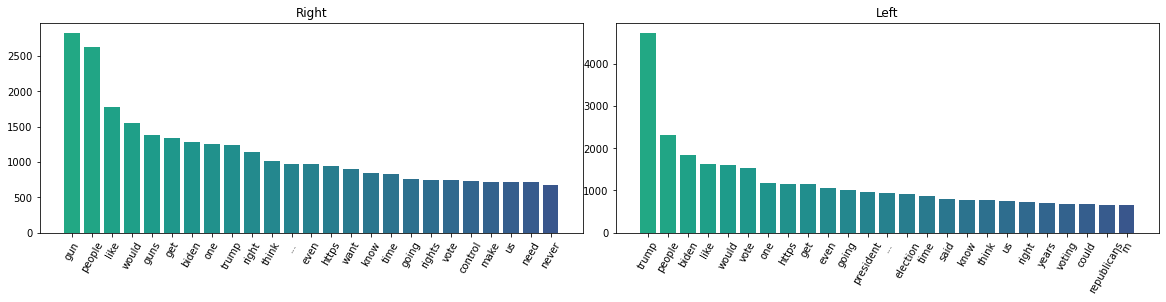

In [318]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(right_bar_words, right_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(left_bar_words, left_bar_counts, color=color )

ax.title.set_text('Right')
ax2.title.set_text('Left')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

plt.savefig('../pics/word_count_bar_graphs.png')

plt.show()

In [315]:
from wordcloud import WordCloud
right_dictionary = dict(zip(right_bar_words, right_bar_counts))
left_dictionary = dict(zip(left_bar_words, left_bar_counts))

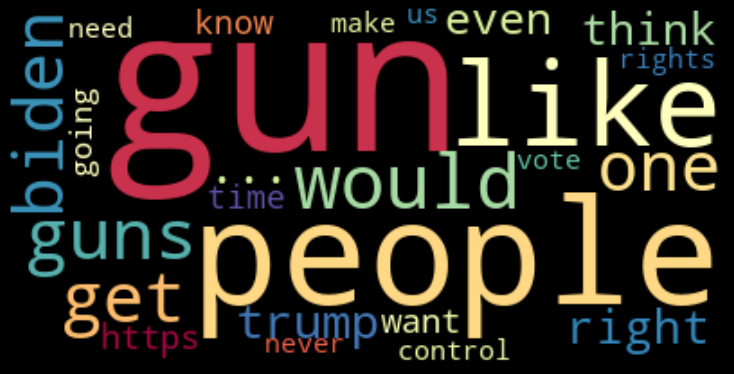

In [319]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(right_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.savefig('../pics/right_wordcloud.png')

plt.show()

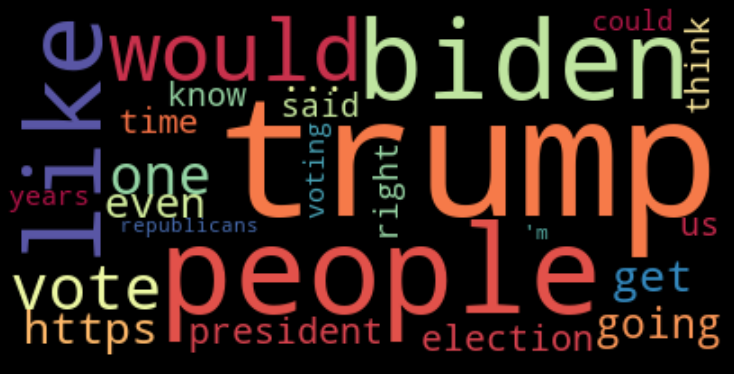

In [320]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(left_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../pics/left_wordcloud.png')

plt.show()

#### Note on these wordcounts

Our model is more complex than a simple bag of words, and so the most used words don't necessarily have a large impact on our model (for example, we use TF IDF).

The charts above are more so just to get an idea of some common words purely for interest.